In [43]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms

from torchsummary import summary
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from PIL import Image

In [44]:
data_paths = {
    'train': './cassavaleafdata/train',
    'valid': './cassavaleafdata/validation',
    'test': './cassavaleafdata/test'
}

# load image from path
def loader(path):
    return Image.open(path)

In [45]:
img_size = 150

train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

train_data = datasets.ImageFolder(
    root=data_paths['train'],
    loader=loader,
    transform=train_transforms
)
valid_data = datasets.ImageFolder(
    root=data_paths['valid'],
    transform=train_transforms
)
test_data = datasets.ImageFolder(
    root=data_paths['test'],
    transform=train_transforms
)

In [46]:
BATCH_SIZE = 512

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)
valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)
test_dataloader = data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE
)

In [47]:
inputs, labels = next(iter(train_dataloader))

In [48]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=6, kernel_size=5, padding='same'
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 35 * 35, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

In [50]:
num_classes = len(train_data.classes)
lenet_model = LeNetClassifier(num_classes)
predictions = lenet_model(inputs)

In [51]:
summary(lenet_model, (3, 150, 150))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 150, 150]         456
├─AvgPool2d: 1-2                         [-1, 6, 75, 75]           --
├─Conv2d: 1-3                            [-1, 16, 71, 71]          2,416
├─AvgPool2d: 1-4                         [-1, 16, 35, 35]          --
├─Flatten: 1-5                           [-1, 19600]               --
├─Linear: 1-6                            [-1, 120]                 2,352,120
├─Linear: 1-7                            [-1, 84]                  10,164
├─Linear: 1-8                            [-1, 5]                   425
Total params: 2,365,581
Trainable params: 2,365,581
Non-trainable params: 0
Total mult-adds (M): 24.59
Input size (MB): 0.26
Forward/backward pass size (MB): 1.65
Params size (MB): 9.02
Estimated Total Size (MB): 10.93


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 150, 150]         456
├─AvgPool2d: 1-2                         [-1, 6, 75, 75]           --
├─Conv2d: 1-3                            [-1, 16, 71, 71]          2,416
├─AvgPool2d: 1-4                         [-1, 16, 35, 35]          --
├─Flatten: 1-5                           [-1, 19600]               --
├─Linear: 1-6                            [-1, 120]                 2,352,120
├─Linear: 1-7                            [-1, 84]                  10,164
├─Linear: 1-8                            [-1, 5]                   425
Total params: 2,365,581
Trainable params: 2,365,581
Non-trainable params: 0
Total mult-adds (M): 24.59
Input size (MB): 0.26
Forward/backward pass size (MB): 1.65
Params size (MB): 9.02
Estimated Total Size (MB): 10.93

In [52]:
optimizer = optim.Adam(lenet_model.parameters())
criterion = nn.CrossEntropyLoss()
loss = criterion(predictions, labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lenet_model.to(device)

LeNetClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=19600, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=5, bias=True)
)

In [53]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=15):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [54]:
train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device)

In [55]:
train_acc, train_loss

(0.4207920792079208, 1.3899329006671906)

In [56]:
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [57]:
eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)

In [58]:
eval_acc, eval_loss

(0.4695606140815246, 1.33484847843647)

In [59]:
num_classes = len(train_data.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), learning_rate)

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch, log_interval=10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt', weights_only=True))
    lenet_model.eval()

| epoch   1 |    10/   12 batches | accuracy    0.433
-----------------------------------------------------------
| End of epoch   1 | Time: 48.93s | Train Accuracy    0.458 | Train Loss    1.417 | Valid Accuracy    0.471 | Valid Loss    1.378 
-----------------------------------------------------------
| epoch   2 |    10/   12 batches | accuracy    0.469
-----------------------------------------------------------
| End of epoch   2 | Time: 62.05s | Train Accuracy    0.750 | Train Loss    1.321 | Valid Accuracy    0.474 | Valid Loss    1.330 
-----------------------------------------------------------
| epoch   3 |    10/   12 batches | accuracy    0.477
-----------------------------------------------------------
| End of epoch   3 | Time: 101.26s | Train Accuracy    0.458 | Train Loss    1.332 | Valid Accuracy    0.489 | Valid Loss    1.324 
-----------------------------------------------------------
| epoch   4 |    10/   12 batches | accuracy    0.480
------------------------------

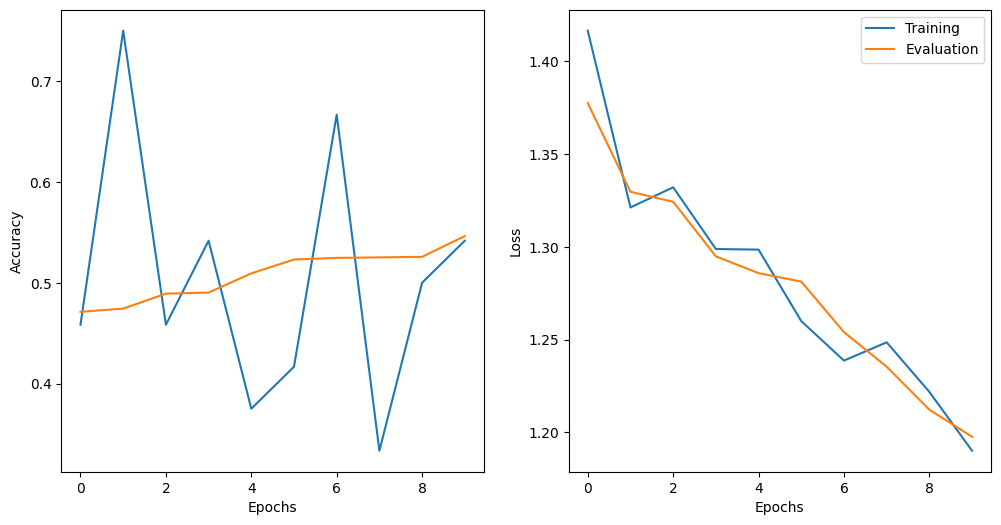

In [60]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)

In [61]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device)
test_acc, test_loss

(0.556498673740053, 1.1732499450445175)

In [62]:
def load_model(model_path, num_classes=5):
    lenet_model = LeNetClassifier(num_classes)
    lenet_model.load_state_dict(torch.load(model_path, weights_only=True))
    lenet_model.eval()
    return lenet_model

def inference(img_path, model):
    image = Image.open(img_path)
    img_size = 150

    img_transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])
    img_new = img_transform(image)
    img_new = torch.unsqueeze(img_new, 0)
    with torch.no_grad():
        predictions = model(img_new)
    preds = nn.Softmax(dim=1)(predictions)
    p_max, yhat = torch.max(preds.data, 1)
    return p_max.item(), yhat.item()

In [63]:
model = load_model('./model/lenet_model.pt')
preds = inference('./cassavaleafdata/test/cbsd/test-cbsd-1.jpg', model)
preds

(0.4802100658416748, 1)

In [64]:
train_data.class_to_idx

{'cbb': 0, 'cbsd': 1, 'cgm': 2, 'cmd': 3, 'healthy': 4}

In [65]:
idx2label = {
  0: 'cbb',
  1: 'cbsd',
  2: 'cgm',
  3: 'cmd',
  4: 'healthy',
}

In [66]:
idx2label[4]

'healthy'